In [32]:
import os
from pathlib import Path

# Geospatial
import geopandas as gpd
import fiona
from rtree.index import Index

import matplotlib.pyplot as plt

In [2]:
# Enable KML drivers for fiona
fiona.drvsupport.supported_drivers['kml'] = 'rw'
fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [24]:
# Set path to directory
dir_path = os.path.join(str(Path.home()), 'Desktop', "forest_mon", "data")

# Path to AoI
aoi_path = os.path.join(dir_path, "rishiri.json")

# Path to WRS shapefile
wrs_path = os.path.join(dir_path, "WRS2_descending.shp")

# Path to Sentinel-2 tiles
#s2_path = os.path.join(dir_path, "S2_tiles.kml")

In [25]:
# Create WRS gdf
wrs = gpd.GeoDataFrame.from_file(wrs_path)

# Create Sentinel-2 gdf
#s2 = gpd.GeoDataFrame.from_file(s2_path)

# Create AoI gdf
aoi = gpd.GeoDataFrame.from_file(aoi_path)

In [26]:
def fast_intersect(aoi, grid):
    """
    Uses spatial indexing to find tiles that intersect 
    the area of interest
    
    Params
    ------
    
    aoi: Geopandas GeoDataFrame
        GeoDataFrame containing area of interest for
        which you want to find an intersection
        
    grid: Geopandas GeoDataFrame
        This will intersect the AOI
        
    Returns
    -------
    precise_matches: Geopandas GeoDataFrame
        This is the resulting gdf that contains grid features
        that intersect area of interest
    """
    
    # Create spatial index for gdf
    grid_spatial_idx = grid.sindex
    
    # Convert AoI coords into something gpd can understand
    aoi_boundaries = (aoi.bounds.minx[0],
                      aoi.bounds.miny[0],
                      aoi.bounds.maxx[0],
                      aoi.bounds.maxy[0])
    
    # Get possible matches using rtree, return as list
    poss_matches_idx = list(grid_spatial_idx.intersection(aoi_boundaries))
    
    # Get possible matches rows from gdb
    poss_matches = grid.iloc[poss_matches_idx]
    
    # Get precise matches by selecting from possible matches
    # where they intersect AoI
    precise_matches = poss_matches[poss_matches.intersects(aoi.geometry[0])]

    return precise_matches

In [36]:
matches = fast_intersect(aoi=aoi, grid=wrs)
matches

,AREA,PERIMETER,PR_,PR_ID,RINGS_OK,RINGS_NOK,PATH,ROW,MODE,SEQUENCE,WRSPR,PR,ACQDayL7,ACQDayL8,geometry
18876,3.58803,7.78452,1765.0,1765.0,1,0,108,29,D,36237,108029,108029,11,3,"POLYGON ((139.90290 44.02357, 139.90200 44.023..."
2632,3.58803,7.78452,1765.0,1765.0,1,0,109,29,D,3749,109029,109029,2,10,"POLYGON ((138.35790 44.02357, 138.35700 44.023..."
2631,3.67742,7.90698,1764.0,1764.0,1,0,109,28,D,3748,109028,109028,2,10,"POLYGON ((138.83610 45.44989, 138.83600 45.449..."


<AxesSubplot:>

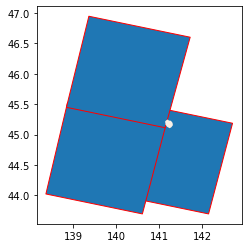

In [35]:
fig, ax = plt.subplots()
matches.plot(ax=ax, edgecolor='red')
aoi.plot(ax=ax, color='linen')